<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/pytorch/t81_558_class_04_3_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 4: Training for Tabular Data**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 4 Material

* Part 4.1: Encoding a Feature Vector for PyTorch Deep Learning [[Video]](https://www.youtube.com/watch?v=i8ASbYqzGJ0&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_04_1_feature_encode.ipynb)
* Part 4.2: PyTorch Multiclass Classification for Deep Neural Networks with ROC and AUC [[Video]](https://www.youtube.com/watch?v=EoqXQTT74vY&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_04_2_multi_class.ipynb)
* **Part 4.3: PyTorch Regression for Deep Neural Networks with RMSE** [[Video]](https://www.youtube.com/watch?v=Ilr_V2fka8s&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_04_3_regression.ipynb)
* Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training [[Video]](https://www.youtube.com/watch?v=03i5bFdrPvY&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_04_4_backprop.ipynb)
* Part 4.5: Neural Network RMSE and Log Loss Error Calculation from Scratch [[Video]](https://www.youtube.com/watch?v=hDlrn4rdIqE&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_04_5_rmse_logloss.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running and maps Google Drive if needed. We also initialize the PyTorch device to either GPU (if available) or CPU.

In [1]:
import torch
import copy

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Early stopping (see Module 3.4)
class EarlyStopping():
  def __init__(self, patience=5, min_delta=1e-2, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""
    
  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False
    
# Make use of a GPU or MPS (Apple) if one is available. (see Module 3.2)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cuda


# Part 4.3: PyTorch Regression for Deep Neural Networks with RMSE

We evaluate regression results differently than classification.  Consider the following code that trains a neural network for regression on the data set **jh-simple-dataset.csv**.  We begin by preparing the data set.

In [2]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values


Next, we create a neural network to fit the data we just loaded.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time

# Define the PyTorch Neural Network
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, out_count)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Numpy to Torch Tensor
x_train = torch.Tensor(x_train).float()
y_train = torch.Tensor(y_train).float()

x_test = torch.Tensor(x_test).float().to(device)
y_test = torch.Tensor(y_test).float().to(device)


# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train,\
  batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test,\
  batch_size=BATCH_SIZE, shuffle=True)


# Create model
model = Net(x.shape[1],1).to(device)

# Define the loss function for regression
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

es = EarlyStopping()

epoch = 0
done = False
while epoch<1000 and not done:
  epoch += 1
  steps = list(enumerate(dataloader_train))
  pbar = tqdm.tqdm(steps)
  model.train()
  for i, (x_batch, y_batch) in pbar:
    y_batch_pred = model(x_batch.to(device)).flatten()
    loss = loss_fn(y_batch_pred, y_batch.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss, current = loss.item(), (i + 1)* len(x_batch)
    if i == len(steps)-1:
      model.eval()
      pred = model(x_test).flatten()
      vloss = loss_fn(pred, y_test)
      if es(model,vloss): done = True
      pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
    else:
      pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 340.34979248046875, vloss: 304.279755, EStop:[0/5]: 100%|██████████| 94/94 [00:01<00:00, 55.77it/s]
Epoch: 2, tloss: 297.6585693359375, vloss: 171.625427, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 103.64it/s]
Epoch: 3, tloss: 93.5086898803711, vloss: 92.472168, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 97.87it/s]
Epoch: 4, tloss: 57.85111618041992, vloss: 54.701862, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 118.26it/s]
Epoch: 5, tloss: 33.064842224121094, vloss: 38.194107, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 96.71it/s]
Epoch: 6, tloss: 15.324446678161621, vloss: 27.398989, EStop:[0/5]: 100%|██████████| 94/94 [00:01<00:00, 80.75it/s]
Epoch: 7, tloss: 39.59227752685547, vloss: 20.762016, EStop:[0/5]: 100%|██████████| 94/94 [00:01<00:00, 86.91it/s]
Epoch: 8, tloss: 19.081485748291016, vloss: 17.003485, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 103.84it/s]
Epoch: 9, tloss: 15.240873336791992, vloss: 14.246161, EStop:[0/5]: 100%

## Mean Square Error

The mean square error (MSE) is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit. If an MSE value has decreased for a model, that is good. However, beyond this, there is not much more you can determine. We seek to achieve low MSE values. The following equation demonstrates how to calculate MSE.

$$ \mbox{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $$

The following code calculates the MSE on the predictions from the neural network.

In [4]:
from sklearn import metrics

# Predict
pred = model(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred.cpu().detach(),y_test.cpu())
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.558396577835083


## Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE. Because of this, the RMSE error is in the same units as the training data outcome. We desire Low RMSE values. The following equation calculates RMSE.

$$ \mbox{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $$

In [5]:
import numpy as np

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred.cpu().detach(),y_test.cpu().detach()))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.7472593784332275


## Lift Chart

We often visualize the results of regression with a lift chart. To generate a lift chart, perform the following activities:

* Sort the data by expected output and plot these values.
* For every point on the x-axis, plot that same data point's predicted value in another color.
* The x-axis is just 0 to 100% of the dataset. The expected always starts low and ends high.
* The y-axis is ranged according to the values predicted.

You can interpret the lift chart as follows:

* The expected and predict lines should be close. Notice where one is above the other.
* The below chart is the most accurate for lower ages.

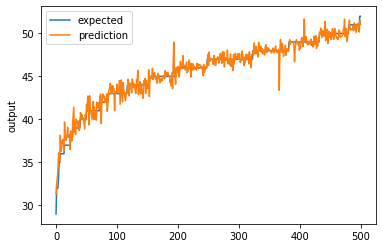

In [6]:

# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Plot the chart
chart_regression(pred.flatten().cpu().detach(),y_test.cpu().detach())